In [2]:
export = True

In [13]:
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from auxiliary_code.helper_functions import *
from shapely.geometry import Polygon
import geopandas as gpd
import seaborn as sns

In [100]:
from sentinelhub import SHConfig

config = SHConfig()
config.sh_client_id = 'CLIENT_ID'
config.sh_client_secret  = 'CLIENT_SECRET'

if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Process API, please provide the credentials (OAuth client ID and client secret).")

c:\Users\casch\anaconda3\envs\geo_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [145]:
def plot_image(image, factor=1.0, clip_range=None, **kwargs):
    """
    Utility function for plotting RGB images.
    """
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])

In [101]:
from sentinelhub import MimeType, CRS, BBox, SentinelHubRequest, SentinelHubDownloadClient, \
    DataCollection, bbox_to_dimensions, DownloadRequest

In [102]:
df_shape = get_shape_file('../geography/Somalia/Som_Admbnda_Adm2_UNDP.shp')
df_bbox = df_shape.bounds

In [103]:
polygon_geom = []
for bounds in df_bbox.to_numpy():
    polygon_geom.append(Polygon(zip(bounds[[0, 0, 2, 2, 0]], bounds[[1, 3, 3, 1, 1]])))

polygons = gpd.GeoDataFrame(index=range(len(polygon_geom)), geometry=polygon_geom)  

In [104]:
no_coast_shape = df_shape.unary_union.union(Polygon([(38, 0), (42, -1.5), (49, 8), (42, 12), (38, 0)]))
mask = np.array([no_coast_shape.contains(polygons['geometry'].iloc[i]) for i in range(len(polygons))])
polygons = polygons.iloc[mask]
df_bbox = df_bbox.iloc[mask]

<AxesSubplot:>

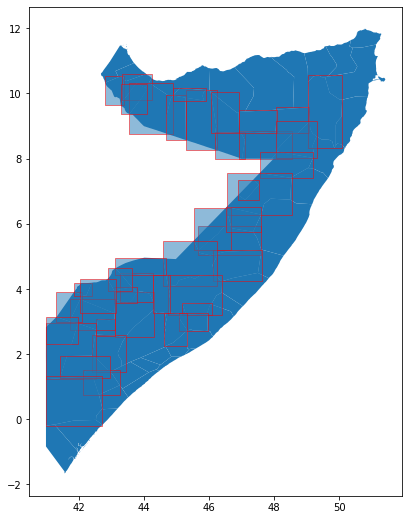

In [163]:
fig, ax = plt.subplots(figsize=(16, 9))
df_shape.plot(ax=ax)
polygons.plot(ax=ax, color=None, edgecolor="red", alpha=0.5)

In [188]:
evalscript_example = """
//VERSION=3
function setup() {
  return {
        input: [{
        bands: ["B08", "B11"],
        units: "DN"
        }],
    output: {
    bands: 2,
    sampleType: "INT16"
    }
  }
}

function evaluatePixel(sample) {
  return [sample.B08, sample.B11];
}
"""

In [189]:
coords= list([42.15, 4, 42.4, 4.2])
resolution = 20
bbox = BBox(bbox=coords, crs=CRS.WGS84)
size = bbox_to_dimensions(bbox, resolution=resolution)

print(f'Image shape at {resolution} m resolution: {size} pixels')

Image shape at 20 m resolution: (1393, 1102) pixels


In [190]:
request = SentinelHubRequest(
    evalscript=evalscript_example,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=("2020-06", "2020-07"),
            mosaicking_order='leastCC'
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=bbox,
    size=size,
    config=config,
)

In [191]:
data = np.array(request.get_data()[0])

In [192]:
B08, B11 = data[:, :, 0].astype('float32'), data[:, :, 1].astype('float32')
NDMI = (B08 - B11)/(B08 + B11)



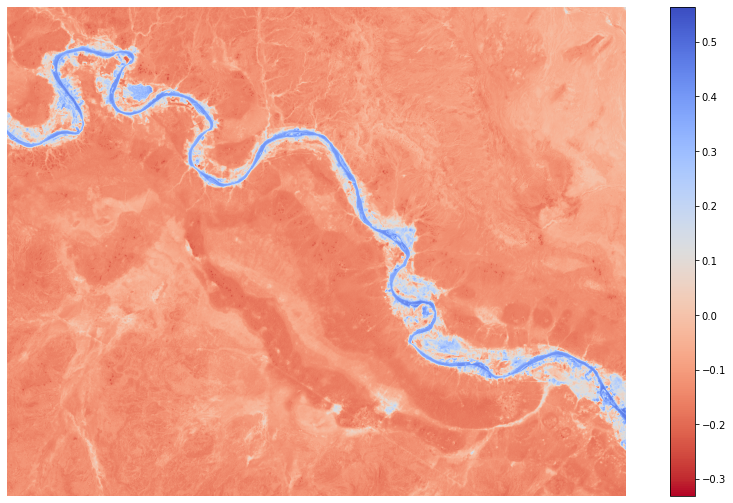

In [233]:
fig, ax = plt.subplots(figsize=(16, 9))
pos = ax.imshow(NDMI, cmap='coolwarm_r')
fig.colorbar(pos, ax=ax)
ax.axis('off')

if export:
    fig.savefig('NDMI_doolow_2020_06')

In [365]:
start = datetime.datetime(2017,1,1)
month = pd.DateOffset(months=1)
edges = [(start + month * i).date().isoformat() for i in range(0, 12*5 + 1)]
slots = [(edges[i], edges[i+1]) for i in range(len(edges)-1)]
slots[0], slots[-1]

(('2017-01-01', '2017-02-01'), ('2021-12-01', '2022-01-01'))

In [366]:
def get_request(time_interval, bbox, size):
    return SentinelHubRequest(
        evalscript=evalscript,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L1C,
                time_interval=time_interval,
                mosaicking_order='leastCC'
            )
        ],
        responses=[
            SentinelHubRequest.output_response('default', MimeType.TIFF)
        ],
        bbox=bbox,
        size=size,
        config=config
    )

In [1]:
df_ndmi = []
path = 'E:/sentinel/soil_moisture/'
df_ndmi = []
resolution = 190
for idx, row in df_bbox.iterrows():
    bbox = BBox(bbox=list(row), crs=CRS.WGS84)
    size = bbox_to_dimensions(bbox, resolution=resolution)
    # create a list of requests
    list_of_requests = [get_request(slot, bbox, size) for slot in slots]
    list_of_requests = [request.download_list[0] for request in list_of_requests]
    # download data with multiple threads
    data = SentinelHubDownloadClient(config=config).download(list_of_requests, max_threads=5)
    data = np.array(data)
    for j in range(len(slots)):
        B08, B11, CLM = data[j, :, :, 0].astype('float32'), data[j, :, :, 1].astype('float32'), data[j, :, :, 2].astype('bool')
        NDMI = (B08 - B11)/(B08 + B11)
        NDMI = NDMI[~CLM]
        df_ndmi.append([np.nanmean(NDMI), np.nanstd(NDMI), slots[j][1], idx])
    np.save(path + idx + '.npy', data)

df_ndmi = pd.DataFrame(df_ndmi).copy()
df_ndmi.columns = ['ndmi_mean', 'ndmi_std', 'date', 'area']
df_ndmi.to_csv('../datasets/ndmi.csv')

In [ ]:
df_moisture = pd.read_csv('../datasets/ndmi.csv', parse_dates=['date'])
df_ipc = pd.read_csv('../datasets/ipc_processed.csv',
                     parse_dates=['date'])
set_index(df_ipc)
set_index(df_moisture)
df_moisture = df_moisture.join(df_ipc['phase3plus_perc']*100)

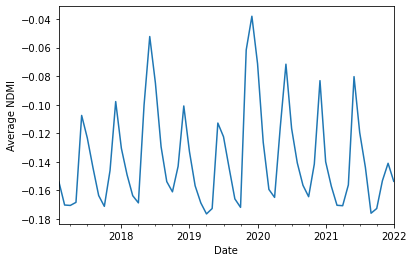

In [ ]:
fig, ax = plt.subplots()

df_moisture.groupby('date').mean().plot(y='ndmi_mean', ax=ax, legend=False)
ax.set_xlabel('Date')
ax.set_ylabel('Average NDMI')
fig.savefig('../figures/NDMI_time.pdf', format='pdf')

In [ ]:
df_moisture['month'] = get_date(df_moisture).month
means = df_moisture.groupby(['area', 'month'])['ndmi_mean'].mean().rename('average')
df_moisture = df_moisture.reset_index().set_index(['area', 'date', 'month']).join(means).droplevel(1)
df_moisture['ndmi_mean'] = df_moisture['ndmi_mean'] - df_moisture['average']

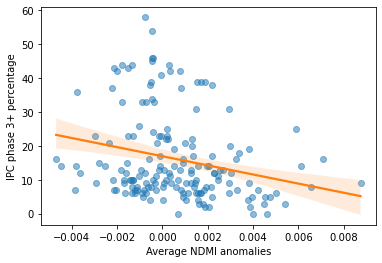

In [ ]:
fig, ax = plt.subplots()

df_moisture['ndmi_mean'] = df_moisture['ndmi_mean'].groupby('area').rolling(12).mean().droplevel(0)
sns.regplot(x='ndmi_mean', y='phase3plus_perc', data=df_moisture, ax=ax, scatter_kws={'alpha': 0.5}, line_kws={'color': 'tab:orange'})
ax.set_xlabel ('Average NDMI anomalies')
ax.set_ylabel('IPC phase 3+ percentage')

fig.savefig('../figures/soil_moisture_reg.pdf', format='pdf')